## Pitching Performance Prediction Model

In [1]:
import pandas as pd
import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    roc_auc_score, accuracy_score,
    precision_score, recall_score,
    f1_score, roc_curve, auc, confusion_matrix
)
# from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
# from sklearn.utils.parallel import Parallel, delayed

In [2]:
# Paths to Kaggle Baseball Databank core files

PITCHING_PATH = "../data/Pitching.csv" 
PEOPLE_PATH   = "../data/Master.csv"  

pitching = pd.read_csv(PITCHING_PATH)
people   = pd.read_csv(PEOPLE_PATH)

print(pitching.head())
people.head()

    playerID  yearID  stint teamID lgID   W   L   G  GS  CG  ...  IBB  WP  \
0  bechtge01    1871      1    PH1  NaN   1   2   3   3   2  ...  NaN NaN   
1  brainas01    1871      1    WS3  NaN  12  15  30  30  30  ...  NaN NaN   
2  fergubo01    1871      1    NY2  NaN   0   0   1   0   0  ...  NaN NaN   
3  fishech01    1871      1    RC1  NaN   4  16  24  24  22  ...  NaN NaN   
4  fleetfr01    1871      1    NY2  NaN   0   1   1   1   1  ...  NaN NaN   

   HBP  BK  BFP  GF    R  SH  SF  GIDP  
0  NaN   0  NaN NaN   42 NaN NaN   NaN  
1  NaN   0  NaN NaN  292 NaN NaN   NaN  
2  NaN   0  NaN NaN    9 NaN NaN   NaN  
3  NaN   0  NaN NaN  257 NaN NaN   NaN  
4  NaN   0  NaN NaN   21 NaN NaN   NaN  

[5 rows x 30 columns]


,playerID,birthYear,birthMonth,birthDay,birthCountry,birthState,birthCity,deathYear,deathMonth,deathDay,...,nameLast,nameGiven,weight,height,bats,throws,debut,finalGame,retroID,bbrefID
0,aardsda01,1981.0,12.0,27.0,USA,CO,Denver,NaN,NaN,NaN,...,Aardsma,David Allan,220.0,75.0,R,R,2004-04-06,2015-08-23,aardd001,aardsda01
1,aaronha01,1934.0,2.0,5.0,USA,AL,Mobile,NaN,NaN,NaN,...,Aaron,Henry Louis,180.0,72.0,R,R,1954-04-13,1976-10-03,aaroh101,aaronha01
2,aaronto01,1939.0,8.0,5.0,USA,AL,Mobile,1984.0,8.0,16.0,...,Aaron,Tommie Lee,190.0,75.0,R,R,1962-04-10,1971-09-26,aarot101,aaronto01
3,aasedo01,1954.0,9.0,8.0,USA,CA,Orange,NaN,NaN,NaN,...,Aase,Donald William,190.0,75.0,R,R,1977-07-26,1990-10-03,aased001,aasedo01
4,abadan01,1972.0,8.0,25.0,USA,FL,Palm Beach,NaN,NaN,NaN,...,Abad,Fausto Andres,184.0,73.0,L,L,2001-09-10,2006-04-13,abada001,abadan01


### Merge pitcher stats with age

Pitching.csv has playerID, yearID, teamID, lgID, IPouts, ERA, SO, BB, HR, etc. People.csv has playerID, birthYear, etc.

### Build label: improvement next season (ERA drop)

In [3]:
# Keep needed columns from People
people_small = people[["playerID", "birthYear"]].copy()

# Merge age into pitching
df = pitching.merge(people_small, on="playerID", how="left")

# Compute age in season (approximate)
df["age"] = df["yearID"] - df["birthYear"]

# Convert IPouts (outs) to innings pitched
df["IP"] = df["IPouts"] / 3.0

# Basic filtering: remove rows without ERA or IP
df = df[df["ERA"].notna()].copy()
df = df[df["IP"].notna()].copy()

# Minimum IP per season to reduce noise
MIN_IP_SEASON = 20.0
df = df[df["IP"] >= MIN_IP_SEASON].copy()

# Sort for later windowing
df["yearID"] = df["yearID"].astype(int)
df = df.sort_values(["playerID", "yearID"]).reset_index(drop=True)

print(df[["playerID", "yearID", "teamID", "lgID", "IP", "ERA", "SO", "BB", "HR", "age"]].head())

### Build label: improvement next season (ERA drop)

# Next-season ERA and IP for each pitcher
df["ERA_next"] = df.groupby("playerID")["ERA"].shift(-1)
df["IP_next"] = df.groupby("playerID")["IP"].shift(-1)

# Only keep seasons with a following season and sufficient IP both years
MIN_IP_LABEL = 30.0
mask_valid = (
    df["ERA_next"].notna() &
    (df["IP"] >= MIN_IP_LABEL) &
    (df["IP_next"] >= MIN_IP_LABEL)
)

df = df[mask_valid].copy()

# Define improvement: ERA drops by at least 0.30
# ERA_DROP = 0.30
# df["improved"] = (df["ERA_next"] <= df["ERA"] - ERA_DROP).astype(int)

# print(df["improved"].value_counts(normalize=True))

ERA_DROP = 0.30
df["improved"] = (df["ERA_next"] <= df["ERA"] - ERA_DROP).astype(int)

# Flip labels so 0 = Improved, 1 = Not Improved
df["improved"] = 1 - df["improved"]

# Derive rate stats
df["K9"] = df["SO"] * 9.0 / df["IP"]
df["BB9"] = df["BB"] * 9.0 / df["IP"]
df["HR9"] = df["HR"] * 9.0 / df["IP"]
df.isna().any()


# MOVED FROM BLOCK 2: Calculate WHIP here
if "H" in df.columns:
    df["WHIP"] = (df["H"] + df["BB"]) / df["IP"]
else:
    df["WHIP"] = np.nan
    
# Clean up infinite values (div by zero protection)
df = df.replace([np.inf, -np.inf], np.nan)

    playerID  yearID teamID lgID         IP   ERA  SO  BB  HR   age
0  aardsda01    2006    CHN   NL  53.000000  4.08  49  28   9  25.0
1  aardsda01    2007    CHA   AL  32.333333  6.40  36  17   4  26.0
2  aardsda01    2008    BOS   AL  48.666667  5.55  49  35   4  27.0
3  aardsda01    2009    SEA   AL  71.333333  2.52  80  34   4  28.0
4  aardsda01    2010    SEA   AL  49.666667  3.44  49  25   5  29.0


### Create 3‑season history windows

Use Pitching.csv columns: ERA, SO, BB, HR, IP plus derived rates K/9, BB/9, HR/9, WHIP (approx: (H+BB)/IP if needed; Pitching.csv has H, BB, SO, HR)

In [4]:
# WHIP = (walks + hits) / IP, if H present
if "H" in df.columns:
    df["WHIP"] = (df["H"] + df["BB"]) / df["IP"]
else:
    df["WHIP"] = np.nan

stat_cols = ["ERA", "K9", "BB9", "HR9", "WHIP", "IP"]

rows = []

for pid, g in df.groupby("playerID"):
    g = g.sort_values("yearID").reset_index(drop=True)
    # i is current season, we need seasons i-2, i-1, i as history, and i+1 exists (already ensured)
    for i in range(2, len(g) - 1):
        current = g.loc[i]
        label = int(current["improved"])

        g3 = g.loc[i-2:i]

        features = {}
        features["playerID"] = pid
        features["yearID"] = int(current["yearID"])

        # Stats: last, 3-year mean, trend
        for col in stat_cols:
            vals = g3[col].values.astype(float)
            features[f"{col}_last"] = vals[-1]
            features[f"{col}_mean3"] = vals.mean()
            features[f"{col}_trend"] = vals[-1] - vals[0]

        # Age context
        features["age"] = current.get("age", np.nan)

        # Team and league context (current season)
        features["teamID"] = current.get("teamID", np.nan)
        features["lgID"] = current.get("lgID", np.nan)

        features["improved"] = label
        rows.append(features)

features_df = pd.DataFrame(rows)
print(features_df.head())
print("Shape:", features_df.shape)
print(features_df["improved"].value_counts(normalize=True))
features_df_Num = features_df.copy()
features_df_Num = features_df_Num.drop(columns=['teamID', 'lgID'])
features_df_Num

    playerID  yearID  ERA_last  ERA_mean3  ERA_trend    K9_last  K9_mean3  \
0  aardsda01    2008      5.55   5.343333       1.47   9.061644  9.134339   
1  aardsda01    2009      2.52   4.823333      -3.88  10.093458  9.725240   
2  aardsda01    2010      3.44   3.836667      -2.11   8.879195  9.344765   
3   aasedo01    1979      4.81   3.986667       1.69   4.661871  4.707582   
4   aasedo01    1980      4.06   4.300000       0.03   3.805714  4.384095   

   K9_trend  BB9_last  BB9_mean3  ...  WHIP_last  WHIP_mean3  WHIP_trend  \
0  0.740889  6.472603   5.319759  ...   1.726027    1.586624    0.424141   
1  0.072839  4.289720   5.164760  ...   1.163551    1.540513   -0.568407   
2 -0.182449  4.530201   5.097508  ...   1.167785    1.352455   -0.558242   
3 -0.114303  3.739209   3.207015  ...   1.494604    1.368056    0.368251   
4 -0.878987  3.394286   3.721115  ...   1.480000    1.485938   -0.003209   

      IP_last    IP_mean3   IP_trend   age  teamID  lgID  improved  
0   48.6666

,playerID,yearID,ERA_last,ERA_mean3,ERA_trend,K9_last,K9_mean3,K9_trend,BB9_last,BB9_mean3,...,HR9_mean3,HR9_trend,WHIP_last,WHIP_mean3,WHIP_trend,IP_last,IP_mean3,IP_trend,age,improved
0,aardsda01,2008,5.55,5.343333,1.47,9.061644,9.134339,0.740889,6.472603,5.319759,...,1.127143,-0.788576,1.726027,1.586624,0.424141,48.666667,44.666667,-4.333333,27.0,0
1,aardsda01,2009,2.52,4.823333,-3.88,10.093458,9.725240,0.072839,4.289720,5.164760,...,0.785934,-0.608729,1.163551,1.540513,-0.568407,71.333333,50.777778,39.000000,28.0,1
2,aardsda01,2010,3.44,3.836667,-2.11,8.879195,9.344765,-0.182449,4.530201,5.097508,...,0.716813,0.166314,1.167785,1.352455,-0.558242,49.666667,56.555556,1.000000,29.0,1
3,aasedo01,1979,4.81,3.986667,1.69,4.661871,4.707582,-0.114303,3.739209,3.207015,...,0.737574,0.337824,1.494604,1.368056,0.368251,185.333333,152.111111,93.000000,25.0,0
4,aasedo01,1980,4.06,4.300000,0.03,3.805714,4.384095,-0.878987,3.394286,3.721115,...,0.765486,-0.036652,1.480000,1.485938,-0.003209,175.000000,179.666667,-3.666667,26.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11643,zoldasa01,1949,4.25,3.910000,1.44,1.867925,1.827514,0.419975,3.056604,2.755811,...,0.618984,0.168204,1.471698,1.406697,0.260342,53.000000,70.888889,-52.666667,31.0,1
11644,zoldasa01,1950,3.96,4.293333,-0.71,2.120419,2.051670,-0.046248,2.968586,3.063952,...,0.731360,0.181501,1.335079,1.447938,-0.201959,63.666667,56.888889,9.666667,32.0,0
11645,zuberbi01,1943,3.89,4.383333,-1.53,4.347458,4.553177,-0.417248,5.644068,5.723115,...,0.350402,-0.238314,1.474576,1.601642,-0.300510,118.000000,113.666667,21.666667,30.0,1
11646,zuberbi01,1944,4.21,3.980000,0.37,4.962617,4.619148,0.415248,4.542056,5.337480,...,0.334879,0.065298,1.448598,1.492813,-0.106665,107.000000,117.222222,-19.666667,31.0,0


### Chatbot block 

In [5]:
# --- BLOCK 3: GENERATE CHATBOT DATA (INFERENCE CSV) ---
# We perform a fresh merge because Block 1 deleted the 2015 data (no ERA_next).

print("Generating Inference Data for Chatbot...")

# 1. Fresh Merge & Basic Setup
inf_df = pitching.merge(people_small, on="playerID", how="left")
inf_df["age"] = inf_df["yearID"] - inf_df["birthYear"]
inf_df["IP"] = inf_df["IPouts"] / 3.0

# 2. Basic Validity Filter (Keep 2015!)
inf_df = inf_df[inf_df["ERA"].notna()]
inf_df = inf_df[inf_df["IP"] >= 20.0]

# 3. CALCULATE RATE STATS (Crucial Step!)
# We must re-calculate these because this is a new dataframe
inf_df["K9"] = (inf_df["SO"] * 9.0) / inf_df["IP"]
inf_df["BB9"] = (inf_df["BB"] * 9.0) / inf_df["IP"]
inf_df["HR9"] = (inf_df["HR"] * 9.0) / inf_df["IP"]
inf_df["WHIP"] = (inf_df["H"] + inf_df["BB"]) / inf_df["IP"]
inf_df = inf_df.replace([np.inf, -np.inf], np.nan)

# 4. Sort
inf_df["yearID"] = inf_df["yearID"].astype(int)
inf_df = inf_df.sort_values(["playerID", "yearID"]).reset_index(drop=True)

# 5. Extract 2015 Features with History
inference_rows = []
stat_cols = ["ERA", "K9", "BB9", "HR9", "WHIP", "IP"]

for pid, g in inf_df.groupby("playerID"):
    # We need the player's last recorded season to be 2015
    if g.iloc[-1]["yearID"] != 2015:
        continue
        
    # We need at least 3 years of history (2013, 2014, 2015)
    if len(g) < 3:
        continue
        
    # Take the last 3 years
    g3 = g.tail(3)
    vals_2013 = g3.iloc[0]
    vals_2014 = g3.iloc[1]
    vals_2015 = g3.iloc[2]
    
    # Ensure they are actually sequential years
    if vals_2015["yearID"] != 2015 or vals_2014["yearID"] != 2014 or vals_2013["yearID"] != 2013:
        continue

    features = {}
    features["playerID"] = pid
    features["yearID"] = 2015
    # Add Name if available (assumes 'nameFirst' is in pitching or people_small)
    # If not, we will merge it later
    
    features["age"] = vals_2015["age"]

    for col in stat_cols:
        v13 = float(vals_2013[col])
        v14 = float(vals_2014[col])
        v15 = float(vals_2015[col])
        
        # --- MODEL INPUTS ---
        features[f"{col}_last"]  = v15
        features[f"{col}_mean3"] = (v13 + v14 + v15) / 3.0
        features[f"{col}_trend"] = v15 - v13

        # --- CHATBOT ANCHORS (For "What-If" logic) ---
        features[f"{col}_2013_baseline"] = v13
        features[f"{col}_2014_baseline"] = v14

    inference_rows.append(features)

# 6. Save to CSV
chatbot_df = pd.DataFrame(inference_rows)

# Merge Names for the User Interface
if "nameFirst" not in chatbot_df.columns:
    # Load people again just to be safe
    names = people[["playerID", "nameFirst", "nameLast", "nameGiven", "birthYear", "birthMonth", "birthDay"]]
    chatbot_df = chatbot_df.merge(names, on="playerID", how="left")

chatbot_df["nameFull"] = chatbot_df["nameFirst"] + " " + chatbot_df["nameLast"]

# Save
chatbot_df.to_csv("inference_stats.csv", index=False)
print(f"SUCCESS: Saved 'inference_stats.csv' with {len(chatbot_df)} players.")

Generating Inference Data for Chatbot...
SUCCESS: Saved 'inference_stats.csv' with 236 players.


### Time‑Aware train/val/test split

In [6]:
min_year = features_df_Num["yearID"].min()
max_year = features_df_Num["yearID"].max()
print("Year range:", min_year, max_year)

# Example split: adjust years to keep enough data
TRAIN_END = 1995
VAL_END = 2010

train_df = features_df_Num[features_df_Num["yearID"] <= TRAIN_END].copy()
val_df   = features_df_Num[(features_df_Num["yearID"] > TRAIN_END) & (features_df["yearID"] <= VAL_END)].copy()
test_df  = features_df_Num[features_df_Num["yearID"] > VAL_END].copy()

print("Train:", len(train_df), "Val:", len(val_df), "Test:", len(test_df))

feature_cols = [c for c in features_df_Num.columns if c not in ["improved", "playerID", "yearID"]]

X_train, y_train = train_df[feature_cols], train_df["improved"]
X_val, y_val     = val_df[feature_cols], val_df["improved"]
X_test, y_test   = test_df[feature_cols], test_df["improved"]
X_train.isna().any()

Year range: 1872 2014
Train: 8550 Val: 2609 Test: 489


ERA_last      False
ERA_mean3     False
ERA_trend     False
K9_last       False
K9_mean3      False
K9_trend      False
BB9_last      False
BB9_mean3     False
BB9_trend     False
HR9_last      False
HR9_mean3     False
HR9_trend     False
WHIP_last     False
WHIP_mean3    False
WHIP_trend    False
IP_last       False
IP_mean3      False
IP_trend      False
age           False
dtype: bool

In [7]:
# Checking Class Proportion in Traing Dataset
y_test.value_counts(normalize=True)

improved
1    0.611452
0    0.388548
Name: proportion, dtype: float64

### Preprocessing

In [8]:
numeric_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = [c for c in X_train.columns if c not in numeric_features]

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

In [9]:
X_train.columns

Index(['ERA_last', 'ERA_mean3', 'ERA_trend', 'K9_last', 'K9_mean3', 'K9_trend',
       'BB9_last', 'BB9_mean3', 'BB9_trend', 'HR9_last', 'HR9_mean3',
       'HR9_trend', 'WHIP_last', 'WHIP_mean3', 'WHIP_trend', 'IP_last',
       'IP_mean3', 'IP_trend', 'age'],
      dtype='str')

### Evaluation Helper

In [9]:
from sklearn.metrics import (
    roc_auc_score, accuracy_score,
    precision_score, recall_score,
    f1_score, roc_curve, auc, confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(name, model, X, y_true):
    # Prob of class 1 = Did Not Improve
    y_proba = model.predict_proba(X)[:, 1]
    y_pred  = model.predict(X)

    auc_val = roc_auc_score(y_true, y_proba)
    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred, zero_division=0)

    print(f"\n{name}:")
    print(f"AUC-ROC: {auc_val:.3f}")
    print(f"Accuracy: {acc:.3f}")
    print(f"Precision (Class 1 = Did Not Improve): {prec:.3f}")
    print(f"Recall (Class 1 = Did Not Improve): {rec:.3f}")
    print(f"F1 (Class 1 = Did Not Improve): {f1:.3f}")

    # ROC curve (positive class = 1 = Did Not Improve)
    fpr, tpr, thresholds = roc_curve(y_true, y_proba, pos_label=1)
    roc_auc = auc(fpr, tpr)

    plt.figure()

    plt.plot(
        fpr, tpr, lw=2,
        label=f"Did Not Improve (Class 1) ROC (AUC = {roc_auc:.2f})"
    )

    plt.plot(
        [0, 1], [0, 1],
        lw=2, linestyle="--",
        label="No Skill (Random Guess)"
    )

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

    plt.title(f"ROC Curve: {name}\nPositive Class = 1 (Did Not Improve) | Negative Class = 0 (Improved)")

    plt.legend(loc="lower right")
    plt.show()


    # Confusion matrix with correct labels
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

    plt.figure(figsize=(5, 4))
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues",
        xticklabels=["Improved (0)", "Did Not Improve (1)"],
        yticklabels=["Improved (0)", "Did Not Improve (1)"]
    )
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.title(f"Confusion Matrix: {name}")
    plt.show()

    return {
        "model": name,
        "auc": auc_val,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1
    }

### Gradient Boosted Decision Trees (GBDT): XGBoost

Fitting 3 folds for each of 32 candidates, totalling 96 fits
Best XGB params: {'clf__colsample_bytree': 0.8, 'clf__learning_rate': 0.03, 'clf__max_depth': 4, 'clf__n_estimators': 200, 'clf__subsample': 0.8}

XGBoost (val):
AUC-ROC: 0.802
Accuracy: 0.704
Precision (Class 1 = Did Not Improve): 0.825
Recall (Class 1 = Did Not Improve): 0.646
F1 (Class 1 = Did Not Improve): 0.725


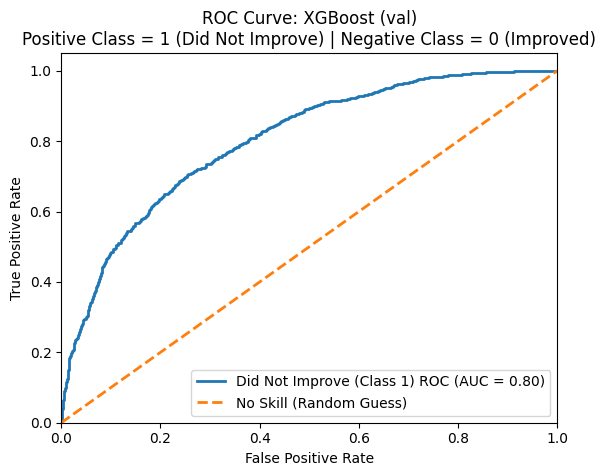

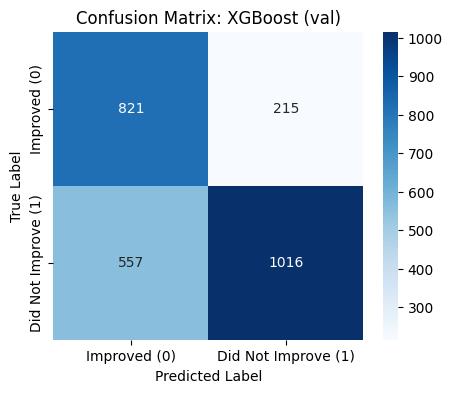


XGBoost (test):
AUC-ROC: 0.811
Accuracy: 0.767
Precision (Class 1 = Did Not Improve): 0.816
Recall (Class 1 = Did Not Improve): 0.799
F1 (Class 1 = Did Not Improve): 0.807


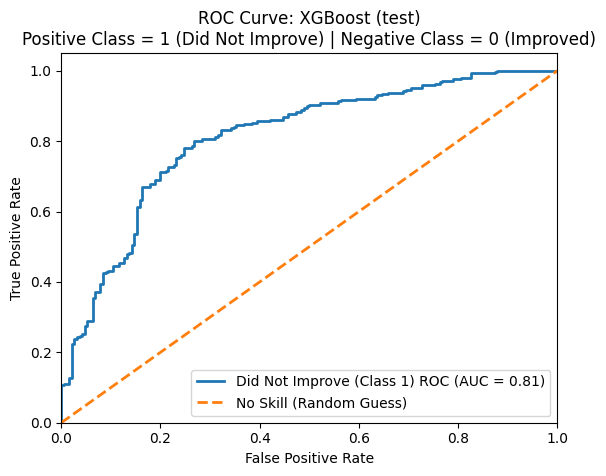

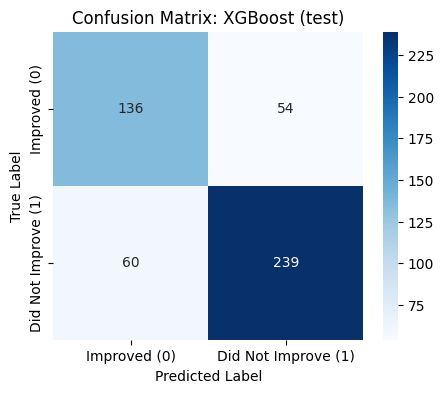

In [14]:
# Usage of the XgBoost parameter "use_label_encoder=False" is deprecated 
# Therefore should not added in the parameter list of XGBClassifier 
xgb_pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        random_state=42,
        tree_method="hist"
    ))
])

xgb_param_grid = {
    "clf__n_estimators": [200, 400],
    "clf__max_depth": [4, 7],
    "clf__learning_rate": [0.03, 0.1],
    "clf__subsample": [0.8, 1.0],
    "clf__colsample_bytree": [0.8, 1.0]
}

xgb_cv = GridSearchCV(
    estimator=xgb_pipe,
    param_grid=xgb_param_grid,
    scoring="roc_auc",
    cv=3,
    n_jobs=-1,
    verbose=1
)

xgb_cv.fit(X_train, y_train)
print("Best XGB params:", xgb_cv.best_params_)

best_xgb = xgb_cv.best_estimator_
xgb_val = evaluate_model("XGBoost (val)", best_xgb, X_val, y_val)
xgb_test = evaluate_model("XGBoost (test)", best_xgb, X_test, y_test)

### Gradient Boosting Probability Distribution

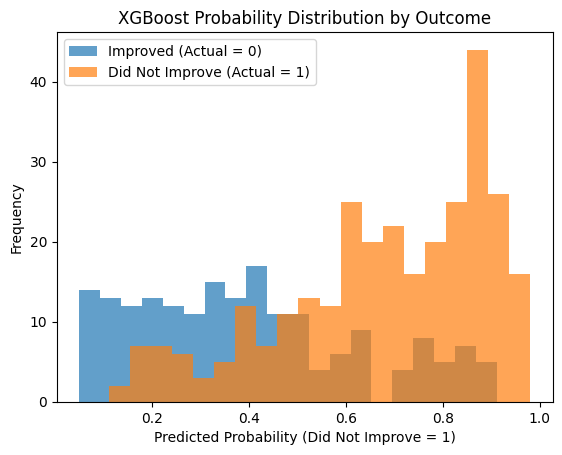

In [15]:
y_proba_xgb = best_xgb.predict_proba(X_test)[:, 1]

# Separate probabilities by actual outcome
proba_improved = y_proba_xgb[y_test == 0]
proba_not_improved = y_proba_xgb[y_test == 1]

plt.figure()

plt.hist(proba_improved, bins=20, alpha=0.7, label="Improved (Actual = 0)")
plt.hist(proba_not_improved, bins=20, alpha=0.7, label="Did Not Improve (Actual = 1)")

plt.xlabel("Predicted Probability (Did Not Improve = 1)")
plt.ylabel("Frequency")
plt.title("XGBoost Probability Distribution by Outcome")
plt.legend()
plt.show()

# Chatbot saving

In [16]:
import joblib

# best_xgb is the full Pipeline (Preprocessing + Model)
# It knows how to handle raw numbers because it has the scaler inside it.
pipeline_to_save = best_xgb 

# Save the whole pipeline
joblib.dump(pipeline_to_save, "pitching_pipeline.pkl")
print("SUCCESS: Full pipeline saved as 'pitching_pipeline.pkl'")

SUCCESS: Full pipeline saved as 'pitching_pipeline.pkl'
